In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data = pd.read_csv('train.csv')

In [3]:
def convert_one_hot(x):
    b = np.zeros((len(x),10))
    for i in range(len(x)):
        a = np.zeros(10)
        a[x[i]] = 1
        b[i] = a
    return b
data = np.array(data)
test_data = data[0:999]
train_data = data[1000:len(data)]
train_labels_number = train_data[:, 0]
train_labels = convert_one_hot(train_labels_number)
train_layers = train_data[:, 1:train_data.shape[0]]/255
test_labels_number = test_data[:, 0]
test_labels = convert_one_hot(test_labels_number)
test_layers = test_data[:, 1:test_data.shape[0]]/255

In [4]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def d_sigmoid(x):
    return(np.exp(x)/np.square(np.exp(x)+1) + 1e-15)

def ReLU(x):
    #return 1/(1 + np.exp(-x))
    return np.maximum(0, x)

def d_ReLU(x):
    #return(np.exp(x)/np.square(np.exp(x)+1))
    return x > 0

def norm(x):
    #print(np.max(x))
    return x/(np.max(x) + 1e-15)

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def ssd(y, p): #sum of squared differences
    squared_diff = np.square(y - p)
    return np.sum(squared_diff)

def d_sd(y, p): #derivative of squared difference
    return 2 * (y - p)

def sum_cross_ent(y, p):
    p += np.full(p.shape, 1e-15) #to prevent log(0)
    return np.sum(-(y * np.log(p) + (1 - y) * np.log(1 - p)))

def d_cross_ent(y, p):
    p += np.full(p.shape, 1e-15) #to prevent division by zero
    return ((1 - y) / (1 - p)) - (y / p)

class Net: # accepts a tuple indicating the number of nodes in each layer. contains the weights array and biases vector for each layer

    def __init__(self, layers): # must have atleast 2 layers (2 items in the layers tuple)
        self.layers = layers #tuple
        self.weights = []
        for i in range(1, len(layers)):
            self.weights.append(np.random.rand(layers[i],layers[i-1])/500)
        self.biases = []
        for i in range(1, len(layers)):
            self.biases.append(np.random.rand(layers[i])/500)
        self.net = [] # contains activations
        for i in range(len(layers)):
            self.net.append(np.zeros((layers[i])))

    def dump(self):
        print("DUMP========")
        print(self.biases)
        print(self.weights)
        print(self.net)
        
    def act(self, x):
        return sigmoid(x)
    
    def d_act(self, x):
        return d_sigmoid(x)
        
    def loss(self, expected, actual): #for one training example
        #return sum_cross_ent(expected, actual)
        return ssd(expected, actual)
    
    def d_loss(self, expected, actual): #for one training example
        #return d_cross_ent(expected, actual)
        return d_sd(expected, actual)
    
    def emp_loss(self, labels, inputs): #empirical loss, for whole testing set
        loss_array = np.zeros((len(inputs)))
        for i in range(len(inputs)):
            output = self.forward(inputs[i])
            loss_array[i] = self.loss(labels[i], output)
        return np.mean(loss_array)
    
    def acc(self, labels_num, inputs):
        successes = 0
        for i in range(len(inputs)):
            output = self.forward(inputs[i])
            prediction = np.where(output == output.max())[0][0]
            if prediction == labels_num[i]:
                successes+=1
        return successes/len(inputs)
    
    def forward(self, input_layer):
        self.net[0] = input_layer
        for i in range(1, len(self.net)):
            self.net[i] = self.act(np.dot(self.weights[i-1], self.net[i-1]) + self.biases[i-1])
        out = self.net[len(self.net)-1]
        normalized = norm(out)
        return softmax(normalized)
    
    def forprop(self, input_batch):
        netlen = len(self.net)
        layer = [0] * netlen
        layer[0] = input_batch
        for i in range(1, netlen):
            TEMP = np.tile(self.biases[i-1], (len(layer[i-1]),1))
            TEMP2 = np.dot(self.weights[i-1], layer[i-1].T).T
            layer[i] = self.act(TEMP2 + TEMP)
        layer[netlen-1] = np.apply_along_axis(norm,1,layer[netlen-1])
        layer[netlen-1] = np.apply_along_axis(softmax,1,layer[netlen-1])
        #print("layer", layer[netlen-1])
        return layer

    def backprop(self, labels, batch): # for one batch
        net = self.forprop(batch)
        
        d_w = []
        for i in range(len(self.layers)-1):
            d_w.append(np.zeros((self.layers[i+1],self.layers[i])))
        d_b = []
        for i in range(len(self.layers)-1):
            d_b.append(np.zeros((self.layers[i+1])))
        d_a = [] 
        for i in range(len(self.layers)):
            d_a.append(np.zeros((self.layers[i])))
            
        for L in range(len(net[0])):
            d_a[len(self.layers)-1] = self.d_loss(net[len(self.layers)-1][L], labels[L])
            for i in reversed(range(len(self.layers)-1)):
                z = np.dot(self.weights[i], net[i][L]) + self.biases[i]
                TEMP0 = np.multiply(self.d_act(z), d_a[i+1])
                TEMP1 = np.dot(TEMP0, self.weights[i])
                d_a[i] = TEMP1/len(net[i+1][L])
                d_b[i] += np.dot(self.d_act(z), d_a[i+1])/len(net[i+1][L])
                d_w[i] += np.outer((d_a[i+1] * self.d_act(z)), net[i][L])
                
                #d_w[i] += (net[i][L] * self.d_act(z) * d_a[i+1])/L
        
        batch_size = len(batch)
        for i in range(len(self.layers)-1):
            d_b[i] /= batch_size
            d_w[i] /= batch_size

        return d_w, d_b

    def train(self, data, labels, batch_size, rate, *, batches=0, epochs=1): #labels and data are arrays of vectors (or 2d arrays), 1 epoch
        #np.random.shuffle(data)
        data_batched = np.zeros((math.floor(len(data)/batch_size), batch_size, self.layers[0]))
        labels_batched = np.zeros((math.floor(len(data)/batch_size), batch_size, self.layers[len(self.layers) - 1]))
        for i in range(math.floor(len(data)/batch_size)):
            for j in range(batch_size):
                data_batched[i][j] = data[i*batch_size + j]
                labels_batched[i][j] = labels[i*batch_size + j]
        
        batch_count = batches
        if (batches == 0):
            batch_count = len(data_batched)

        step = 10
        batch_axis = np.linspace(0,(batch_count*epochs//step)*step, batch_count*epochs//step)
        losses = np.zeros(batch_count*epochs//step)
        accuracies = np.zeros(batch_count*epochs//step)
            
        for E in range(epochs):
            print("\nepoch", E)
            for i in range(batch_count):
                #self.dump()

                d_weights, d_biases = self.backprop(labels_batched[i], data_batched[i])

                for j in range(len(self.layers)-1):
                    self.weights[j] = np.subtract(self.weights[j], rate * d_weights[j])
                    #self.weights[j] = self.weights[j]/np.linalg.norm(self.weights[j])
                    self.biases[j] = np.subtract(self.biases[j], rate * d_biases[j])
                    #self.biases[j] = self.biases[j]/np.linalg.norm(self.biases[j])
                if i % step == 0:
                    this_loss = self.emp_loss(test_labels, test_layers)
                    this_acc = self.acc(test_labels_number, test_layers)
                    
                    step_index = (i + (batch_count * E)) // step
                    losses[step_index-1] = this_loss
                    accuracies[step_index-1] = this_acc
                    
                    #print("batch", i)
                    #print("loss:", this_loss)
                    #print("accuracy:", this_acc)
                    #self.dump()
        return (batch_axis, losses, accuracies)
    
    #takes a 28x28 image and returns a digit
    def predict(self, input_image):
        layer = input_image.flatten()
        out = self.forward(layer)
        return np.argmax(out)
            
        

create net
train

epoch 0

epoch 1

epoch 2

epoch 3

epoch 4

epoch 5

epoch 6

epoch 7

epoch 8

epoch 9


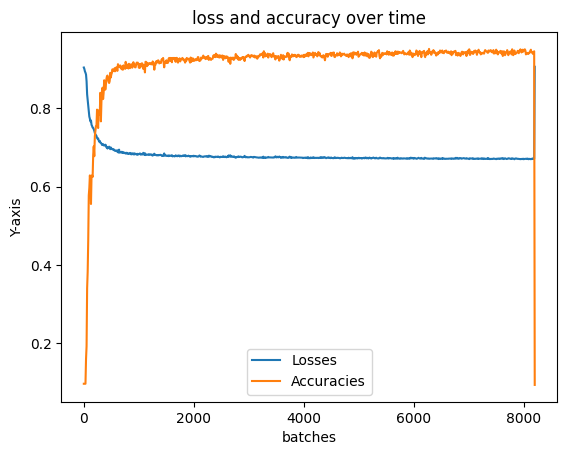

In [5]:
print("create net")
testnet = Net((784, 20, 10))

print("train")
res = testnet.train(train_layers, train_labels, 50, 10, epochs=10)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the lines
ax.plot(res[0], res[1], label='Losses')
ax.plot(res[0], res[2], label='Accuracies')

# Customize the chart
ax.set_title('loss and accuracy over time')
ax.set_xlabel('batches')
ax.set_ylabel('Y-axis')
ax.legend()

# Display the chart
plt.show()

In [7]:
testnet.acc(test_labels_number, test_layers)

0.9459459459459459

In [8]:
# Prediction Interface

In [9]:
imgs = np.delete(data, 0, axis=1)
imgs = np.array([row.reshape(28, 28) for row in imgs])

In [17]:
select = 17

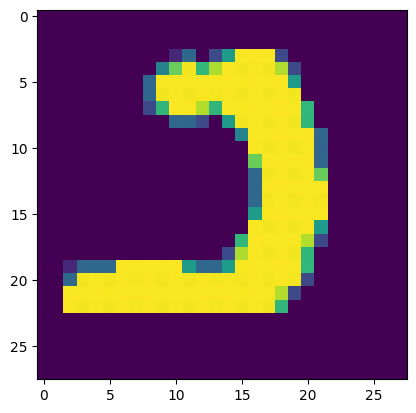

prediction: 3
truth: 2


C:\Users\muyan\AppData\Local\Temp\ipykernel_6656\643650401.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


In [74]:
plt.imshow(imgs[select])
plt.show()
print('prediction:', testnet.predict(imgs[select]))
print('truth:', data[select][0])
select+=1
